In [34]:
import torch
from d2l import torch as d2l
import os   

In [35]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集。"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])


Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [36]:
print(raw_text[:3])

Go.


In [37]:
char_test = ','
char_test in  set( '!,?.')

True

In [38]:
def preprocess_nmt( text ):
    def no_space( char , pre_char ):
        # 判断当前字符是否在集合当中，并且检查前一个字符是否为空格，如果在集合当中并且前一个字符不是空格就得到标志位
        return char in set( '!,?.') and pre_char!=' '
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [ ' '+char if i>0 and no_space( char , text[i-1] )  else char 
              for i , char in enumerate( text ) ] 
    return ''.join( out )

text = preprocess_nmt( raw_text )
print( text[:80] )

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [39]:
def tokensize_nmt( text , num_examples  = None  ):
    #词元化'英语-法语'数据集
    source , target = [],[]
    for i , line in enumerate( text.split('\n') ):
        #将文本每一行截断为列表
        if num_examples and i > num_examples:
            break#输出样例，比如说给了10，就输出十行
        part = line.split('\t')#将每一行截断为两个元素，分别为英语和法语的词元对
        if len( part ) == 2:
            source.append( part[0].split( ' ' ) )
            target.append( part[1].split( ' ' ) )
    return source , target
    

In [40]:
source , target = tokensize_nmt( text )
source[:6] , target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

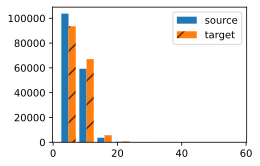

In [41]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');


In [42]:
src_vocab = d2l.Vocab( source , min_freq= 2 , reserved_tokens= ['<pad>' ,'<bos>','<eos>' ])

len( src_vocab )

10012

In [43]:
def truncate_pad( line , num_steps , padding_tokens ):
    if len( line )> num_steps:
        return line[:num_steps]#时间步大小
    return line+[padding_tokens]*( num_steps - len( line ))


In [44]:
truncate_pad( src_vocab[ source[0] ] , 10 ,  src_vocab[ '<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

## 注意'pad'返回的是0这个标量，现在尝试利用广播机制进行比对操作

In [45]:
src_vocab['pad']

0

In [46]:
x = torch.arange( 0, 16 ).reshape( 4 , 4 )
x == 1 #推测是用到了广播机制，将1扩展到shape为( 4 ,4 )，然后进行比对返回的是一个bool的tensor

tensor([[False,  True, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])

In [47]:
def build_array_nmt( lines , vocab , num_steps ):
    '''将文本数据转换为索引，并且记录每个序列的长度'''
    lines = [ vocab[i]  for i in lines ] #转换为索引
    #添加结束'eos'标志符
    lines = [  line + [ vocab['<eos>'] ]   for line in lines ]
    #对每个序列进行截断和padding,并将其tensor
    array = torch.Tensor( [ truncate_pad( line , num_steps , vocab[ '<pad>' ]  )  for line in lines ] )
    #记录每个文本序列的长度,并用到上述的广播机制
    valid_len = ( array != vocab['<pad>'] ).type( torch.int32 ).sum( 1 )#这个sum传入的1就是将每列固定，进行按列相加,因为比对的输出结果是二维数组
    return array , valid_len

### 最后，我们定义 load_data_nmt 函数来返回数据迭代器，以及源语言和目标语言的两种词汇表。

In [48]:
def load_data_nmt( batch_size , num_steps , num_examples = 600 ):
    text = preprocess_nmt( read_data_nmt() )
    source , target = tokensize_nmt( text , num_examples )
    src_vocab =  d2l.Vocab( source , min_freq= 2 , reserved_tokens=[ '<pad>' , '<bos>' , '<eos>' ] )
    tgt_vocab =  d2l.Vocab( target , min_freq= 2 , reserved_tokens=[ '<pad>' , '<bos>' , '<eos>' ]) 
    src_array , src_valid_len = build_array_nmt( source , src_vocab , num_steps  )
    tgt_array , tgt_valid_len = build_array_nmt( source , tgt_vocab , num_steps )
    data_arrays = ( src_array , src_valid_len , tgt_array , tgt_valid_len )
    data_iter = d2l.load_array( data_arrays , batch_size )
    return data_iter , src_vocab , tgt_vocab
    


In [49]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break


X: tensor([[14, 33,  4,  3,  1,  1,  1,  1],
        [76,  8,  5,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[0, 0, 4, 3, 1, 1, 1, 1],
        [0, 0, 5, 3, 1, 1, 1, 1]], dtype=torch.int32)
valid lengths for Y: tensor([4, 4])
